In [2]:
import torch
import evaluation
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import *
from MAML import *
import json
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import os

# MiniImagenet

## Load models

In [12]:
testdata = MiniImagenet(100, 1, 10, 5, mode='test')

In [6]:
vte = evaluation.load_metalearner("best_models/MiniImagenet/vte-maml/settings.json", testdata,
                                  "best_models/MiniImagenet/vte-maml/model.pkl",
                                  "best_models/MiniImagenet/vte-maml/modulation.pkl")

mmaml = evaluation.load_metalearner("best_models/MiniImagenet/mmaml/settings.json", testdata,
                                    "best_models/MiniImagenet/mmaml/model.pkl",
                                    "best_models/MiniImagenet/mmaml/modulation.pkl")

maml = evaluation.load_metalearner("best_models/MiniImagenet/maml/settings.json", testdata,
                                   "best_models/MiniImagenet/maml/model.pkl",
                                   "best_models/MiniImagenet/maml/modulation.pkl")

### VTE-MAML

In [8]:
acc, ece, mce = [], [], []
for i in range(10):
    a, e, m = evaluation.score(vte, testdata, 10, 10)
    acc.append(a)
    ece.append(e)
    mce.append(m)

acc = torch.Tensor(acc)
ece = torch.Tensor(ece)
mce = torch.Tensor(mce)

print(acc.mean())
print(acc.std()/10**0.5*1.96)
print(ece.mean())
print(ece.std()/10**0.5*1.96)
print(mce.mean())
print(mce.std()/10**0.5*1.96)

100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


tensor(0.4896)
tensor(0.0014)
tensor(0.0396)
tensor(0.0012)
tensor(0.1742)
tensor(0.0045)


### Multimodal-MAML

In [10]:
acc, ece, mce = [], [], []
for i in range(10):
    a, e, m = evaluation.score(mmaml, testdata, 1, 10)
    acc.append(a)
    ece.append(e)
    mce.append(m)

acc = torch.Tensor(acc)
ece = torch.Tensor(ece)
mce = torch.Tensor(mce)

print(acc.mean())
print(acc.std()/10**0.5*1.96)
print(ece.mean())
print(ece.std()/10**0.5*1.96)
print(mce.mean())
print(mce.std()/10**0.5*1.96)

100%|██████████| 100/100 [00:01<00:00, 67.79it/s]


tensor(0.4990)
tensor(0.0008)
tensor(0.0710)
tensor(0.0016)
tensor(0.3176)
tensor(0.0092)


### MAML

In [11]:
acc, ece, mce = [], [], []
for i in range(10):
    a, e, m = evaluation.score(maml, testdata, 1, 10)
    acc.append(a)
    ece.append(e)
    mce.append(m)

acc = torch.Tensor(acc)
ece = torch.Tensor(ece)
mce = torch.Tensor(mce)

print(acc.mean())
print(acc.std()/10**0.5*1.96)
print(ece.mean())
print(ece.std()/10**0.5*1.96)
print(mce.mean())
print(mce.std()/10**0.5*1.96)

100%|██████████| 100/100 [00:00<00:00, 138.57it/s]


tensor(0.4758)
tensor(0.0013)
tensor(0.0575)
tensor(0.0007)
tensor(0.2548)
tensor(0.0052)


# Calibration visualization

In [18]:
def get_calibration_df(metalearner, testdata):
    score = 0
    final_preds = None
    targets = None

    for (x_s, x_q, y_s, y_q) in tqdm(testdata):
        predictions = None
        x_s, x_q, y_s, y_q = map(lambda x: x.to(metalearner.device), (x_s, x_q, y_s, y_q))
        for i in range(5):

            args = metalearner.finetune(x_s, y_s)
            with torch.no_grad():
                if type(args) == tuple:
                    pred = metalearner.predict(x_q, *args)
                else:
                    pred = metalearner.predict(x_q, args)
                if pred.shape[-1] > 1:
                    pred = torch.nn.Softmax(dim=-1)(pred)
                pred = pred.view(*pred.shape, 1)
                if predictions is None:
                    predictions = pred
                else:
                    predictions = torch.cat([predictions, pred], dim=2)

        final_pred = predictions.mean(dim=2)

        score += metalearner.get_accuracy(final_pred, y_q)
        if final_preds is None:
            final_preds = final_pred
            targets = y_q
        else:
            final_preds = torch.cat([final_preds, final_pred], dim=0)
            targets = torch.cat([targets, y_q], dim=0)

    if final_preds.shape[-1] > 1:
        final_preds = final_preds.view(-1)
        onehot = torch.zeros(targets.shape[0], targets.max()+1)
        onehot[range(onehot.shape[0]), targets] = 1
        targets = onehot.view(-1)

    print(final_preds.max())
    buckets = (final_preds * 10-0.01).abs().floor()/10
    print(buckets)
    results = pd.DataFrame([buckets.flatten().detach().cpu().numpy(), targets.flatten().detach().cpu().numpy()]).T
    results = pd.concat([results.groupby(0).mean(),results.groupby(0).count()], axis=1)
    results.columns = ["% positive", "number predicted"]
    return results

In [20]:
vte_df = get_calibration_df(vte, testdata)

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


tensor(0.9963, device='cuda:0')
tensor([0.0000, 0.4000, 0.0000,  ..., 0.3000, 0.2000, 0.1000], device='cuda:0')


In [21]:
mmaml_df = get_calibration_df(mmaml, testdata)

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


tensor(0.9981, device='cuda:0')
tensor([0.0000, 0.1000, 0.1000,  ..., 0.7000, 0.0000, 0.1000], device='cuda:0')


In [23]:
maml_df = get_calibration_df(maml, testdata)

100%|██████████| 100/100 [01:03<00:00,  1.59it/s]


tensor(0.9954, device='cuda:0')
tensor([0.4000, 0.0000, 0.2000,  ..., 0.4000, 0.0000, 0.0000], device='cuda:0')


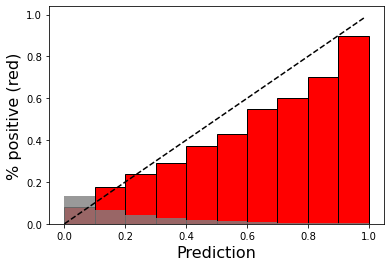

In [24]:
plt.bar(np.array(vte_df.index).round(1)+0.05, vte_df['% positive'], width=0.1, color='red', edgecolor='black')
plt.bar(np.array(vte_df.index).round(1)+0.05, vte_df['number predicted']/80000, width=0.1, color='grey', alpha=0.8)
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c='black', linestyle="--")
plt.xlabel("Prediction", fontsize=16)
plt.ylabel("% positive (red)", fontsize=16)
plt.savefig("calibration_vte_imagenet.pdf", format='pdf')

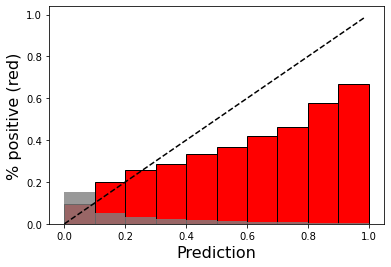

In [25]:
plt.bar(np.array(mmaml_df.index).round(1)+0.05, mmaml_df['% positive'], width=0.1, color='red', edgecolor='black')
plt.bar(np.array(mmaml_df.index).round(1)+0.05, mmaml_df['number predicted']/80000, width=0.1, color='grey', alpha=0.8)
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c='black', linestyle="--")
plt.xlabel("Prediction", fontsize=16)
plt.ylabel("% positive (red)", fontsize=16)
plt.savefig("calibration_mmaml_imagenet.pdf", format='pdf')

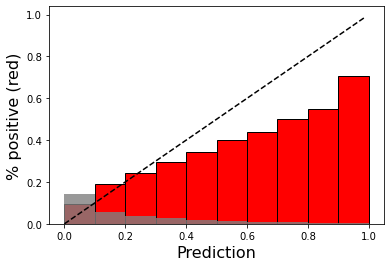

In [26]:
plt.bar(np.array(maml_df.index).round(1)+0.05, maml_df['% positive'], width=0.1, color='red', edgecolor='black')
plt.bar(np.array(maml_df.index).round(1)+0.05, maml_df['number predicted']/80000, width=0.1, color='grey', alpha=0.8)
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c='black', linestyle="--")
plt.xlabel("Prediction", fontsize=16)
plt.ylabel("% positive (red)", fontsize=16)
plt.savefig("calibration_maml_imagenet.pdf", format='pdf')